<a href="https://colab.research.google.com/github/mobraine/MAIS-202-Final-Prediction-of-recidivism-model/blob/master/competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Import libraries and datasets

In [ ]:
import numpy as np
import csv
from tensorflow import keras as ks
import math

import matplotlib.pyplot as plt

In [ ]:
# So I found a cool way to download all our files to the colab automatically:
# https://www.kaggle.com/docs/api#interacting-with-competitions

%env KAGGLE_USERNAME=samongervais
%env KAGGLE_KEY=1bec3488b26cf1cef01f7b84cbbb7996
! kaggle competitions download mais202-fall2019

env: KAGGLE_USERNAME=samongervais
env: KAGGLE_KEY=1bec3488b26cf1cef01f7b84cbbb7996
  0% 0.00/127 [00:00<?, ?B/s]
100% 127/127 [00:00<00:00, 265kB/s]
 24% 5.00M/20.7M [00:00<00:00, 28.8MB/s]
100% 20.7M/20.7M [00:00<00:00, 68.7MB/s]
  0% 0.00/429k [00:00<?, ?B/s]
100% 429k/429k [00:00<00:00, 129MB/s]
  0% 0.00/165k [00:00<?, ?B/s]
100% 165k/165k [00:00<00:00, 55.5MB/s]
 95% 49.0M/51.7M [00:01<00:00, 35.8MB/s]
100% 51.7M/51.7M [00:01<00:00, 50.9MB/s]


In [ ]:
train_imgs = np.load("train_images.npy.zip")["train_images"]
test_imgs = np.load("test_images.npy.zip")["test_images"]

# add empty color dimension, like in that cheat-colab
train_imgs = np.expand_dims(train_imgs, -1).astype(np.int8)
test_imgs = np.expand_dims(test_imgs, -1).astype(np.int8)

with open("train_labels.csv") as file:
  train_labels = [row[1] for row in csv.reader(file)]  #Reads in the second column of the csv (the actual labels)...
del(train_labels[0])  #... and removes the heading
train_labels = np.array(train_labels)

### 2. Preprocessing

### Mapping between integer label and text label

In [ ]:
with open("label_int_to_str_mapping.csv") as file:
  int_labels = [row[0] for row in csv.reader(file)]
with open("label_int_to_str_mapping.csv") as file:
  str_labels = [row[1] for row in csv.reader(file)]

# deleted the first entry in int_labels, which is only a title
int_labels = int_labels[1:]
str_labels = str_labels[1:]

mapping = {}
for i in range(len(int_labels)):
  mapping[int_labels[i]] = str_labels[i]
mapping

{'0': 'T-shirt/top',
 '1': 'Trouser',
 '2': 'Pullover',
 '3': 'Dress',
 '4': 'Coat',
 '5': 'Sandal',
 '6': 'Shirt',
 '7': 'Sneaker',
 '8': 'Bag',
 '9': 'Ankle boot'}

### Visualization

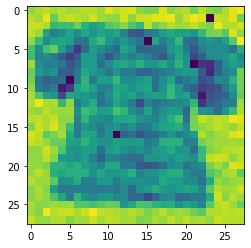

Shirt


In [ ]:
#index of the training image you want to display
#note that max index is 49999
index = 0

# provided in the competition instructions
def show_image(arr):
    dim = int(math.sqrt(arr.size))
    two_d = (np.reshape(arr, (dim, dim)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    plt.show()

show_image(train_imgs[index])

#show the label of the clothing
print(mapping[train_labels[index]])


### Clear Cut Outline

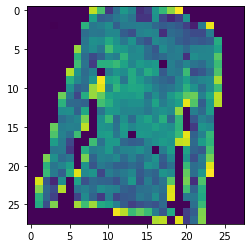

In [ ]:
def outline(image):
  for i in range(28):
    for j in range(28):
      if image[i][j] > 20:
      #  image[i][j] = 0
      #else:
        image[i][j] = 255

for image in train_imgs:
  outline(image)

show_image(train_imgs[10])



### Generate More Data Through Rotation

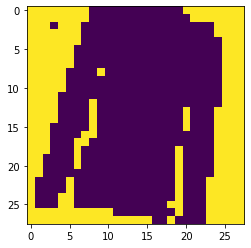

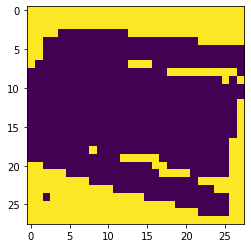

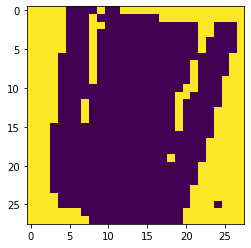

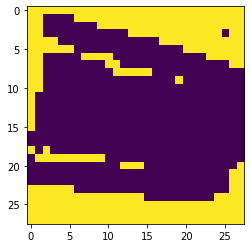

In [ ]:
def rotate(image):
  rotated_img = np.rot90(image)
  return rotated_img

ccw_90_train_imgs = np.empty((50000, 28, 28, 1))
for i in range(len(train_imgs)):
  ccw_90_train_imgs[i] = (rotate(train_imgs[i]))

ccw_180_train_imgs = np.empty((50000, 28, 28, 1))
for i in range(len(ccw_90_train_imgs)):
  ccw_180_train_imgs[i] = (rotate(ccw_90_train_imgs[i]))

ccw_270_train_imgs = np.empty((50000, 28, 28, 1))
for i in range(len(ccw_180_train_imgs)):
  ccw_270_train_imgs[i] = (rotate(ccw_180_train_imgs[i]))

show_image(train_imgs[10])
show_image(ccw_90_train_imgs[10])
show_image(ccw_180_train_imgs[10])
show_image(ccw_270_train_imgs[10])

### Generate More Data Through Reflection

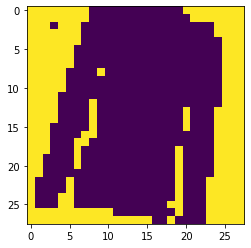

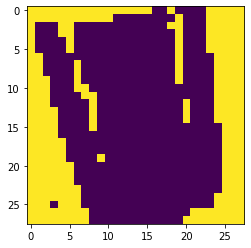

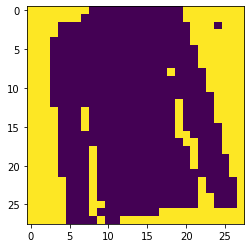

In [ ]:
def up_down_flip(image):
  flipped_img = np.flipud(image)
  return flipped_img

def left_right_flip(image):
  flipped_img = np.fliplr(image)
  return flipped_img

up_down_train_imgs = np.empty((50000, 28, 28, 1))
for i in range(len(train_imgs)):
  up_down_train_imgs[i] = (up_down_flip(train_imgs[i]))

left_right_train_imgs = np.empty((50000, 28, 28, 1))
for i in range(len(train_imgs)):
   left_right_train_imgs[i] = (left_right_flip(train_imgs[i]))

show_image(train_imgs[10])
show_image(up_down_train_imgs[10])
show_image(left_right_train_imgs[10])


### Merge all variations of the training set together

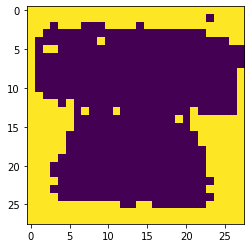

Shirt


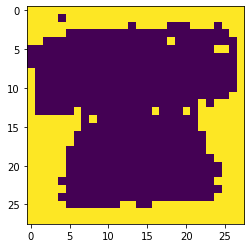

Shirt


In [ ]:
# Combine all variations of the training images together
super_train_imgs = np.append(train_imgs, left_right_train_imgs, axis = 0)
#super_train_imgs = np.append(super_train_imgs, up_down_train_imgs, axis = 0)
#super_train_imgs = np.append(super_train_imgs, ccw_90_train_imgs, axis = 0)
#super_train_imgs = np.append(super_train_imgs, ccw_180_train_imgs, axis = 0)
#super_train_imgs = np.append(super_train_imgs, ccw_270_train_imgs, axis = 0)

# Combine all training labels together
super_train_labels = np.append(train_labels, train_labels)

# Show images with their labels to check
for k in range(2):
  index = (50000*k)
  show_image(super_train_imgs[index])
  print(mapping[super_train_labels[index]])


In [ ]:
super_train_labels.shape

(100000,)

### 3. Model

In [ ]:
model = ks.models.Sequential()
model.add(ks.layers.BatchNormalization(input_shape=train_imgs.shape[1:]))
model.add(ks.layers.Conv2D(128, (5, 5), padding='same', activation='elu', name="conv1"))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(ks.layers.Dropout(0.2))

model.add(ks.layers.BatchNormalization(input_shape=train_imgs.shape[1:]))
model.add(ks.layers.Conv2D(128, (5, 5), padding='same', activation='elu', name="conv2"))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(ks.layers.Dropout(0.2))

model.add(ks.layers.BatchNormalization(input_shape=train_imgs.shape[1:]))
model.add(ks.layers.Conv2D(256, (5, 5), padding='same', activation='elu', name="conv3"))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(ks.layers.Dropout(0.2))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(256))
model.add(ks.layers.Activation('elu'))
model.add(ks.layers.Dropout(0.25))
model.add(ks.layers.Dense(10))
model.add(ks.layers.Activation('softmax'))

Compile the model

In [ ]:
model.compile(loss='sparse_categorical_crossentropy' , optimizer=ks.optimizers.Adam(learning_rate=1e-3), metrics=['sparse_categorical_accuracy'])

Run the model

In [ ]:
history = model.fit(train_imgs, train_labels, epochs=10, validation_split=0.1, batch_size=50 )
model.save_weights("weights.pickle")


Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 41s 908us/sample - loss: 1.1230 - sparse_categorical_accuracy: 0.6697 - val_loss: 0.6249 - val_sparse_categorical_accuracy: 0.7812
Epoch 2/10
45000/45000 [==============================] - 42s 924us/sample - loss: 0.6155 - sparse_categorical_accuracy: 0.7765 - val_loss: 0.6132 - val_sparse_categorical_accuracy: 0.7702
Epoch 3/10
45000/45000 [==============================] - 42s 922us/sample - loss: 0.5887 - sparse_categorical_accuracy: 0.7834 - val_loss: 0.5913 - val_sparse_categorical_accuracy: 0.8016
Epoch 4/10
45000/45000 [==============================] - 41s 902us/sample - loss: 0.5749 - sparse_categorical_accuracy: 0.7924 - val_loss: 0.5567 - val_sparse_categorical_accuracy: 0.8020
Epoch 5/10
45000/45000 [==============================] - 41s 900us/sample - loss: 0.5253 - sparse_categorical_accuracy: 0.8072 - val_loss: 0.5294 - val_sparse_categorical_accuracy: 0.8138
Epoch 

In [ ]:
test_labels = [img.index(max(img)) for img in model.predict(test_imgs).tolist()]

In [ ]:
def sample_layer(layer, image):
  arr = ks.models.Model(inputs=model.input, outputs=model.get_layer(name=layer).output).predict(np.array([image]))
  arr = np.moveaxis(arr[0], 2, 0)
  print(arr.shape)
  return arr

Original:


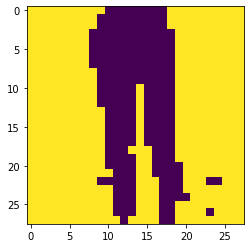

Convolutions:
(64, 28, 28)


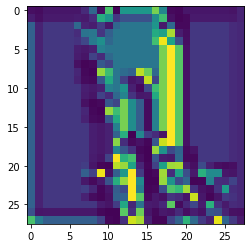

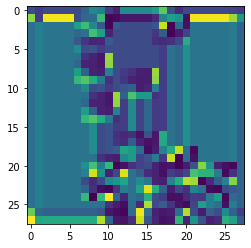

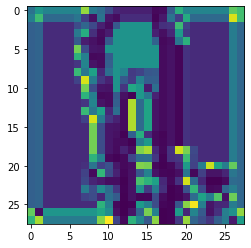

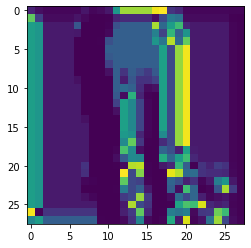

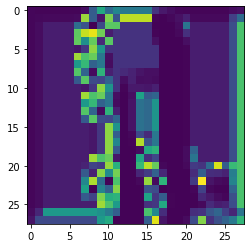

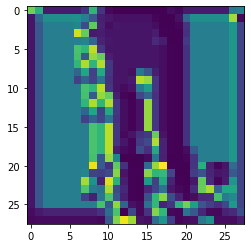

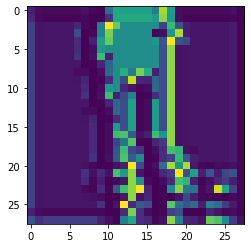

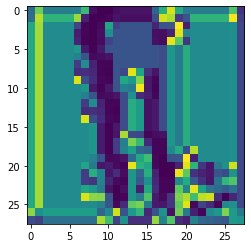

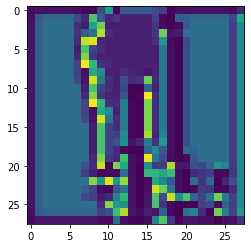

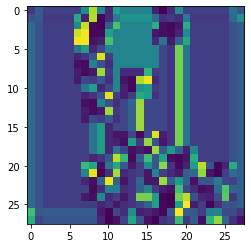

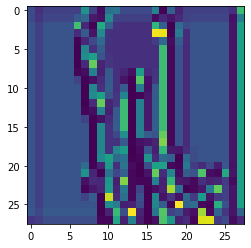

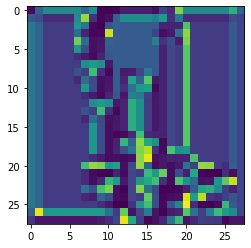

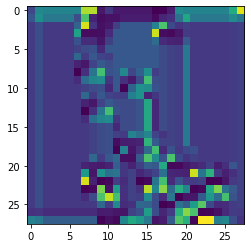

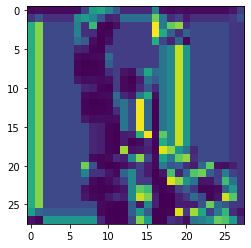

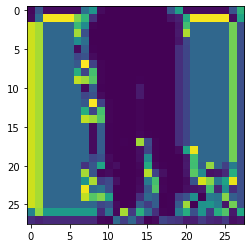

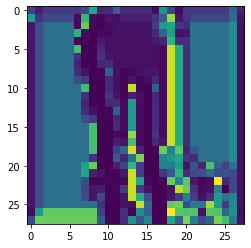

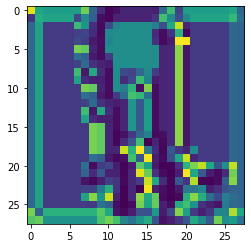

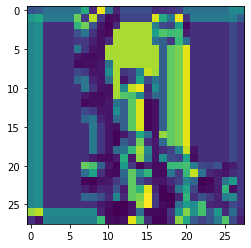

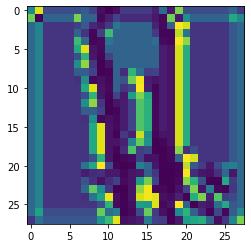

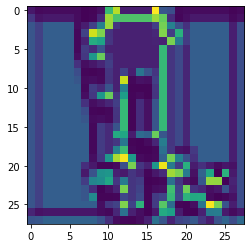

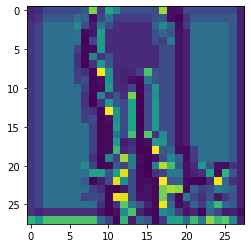

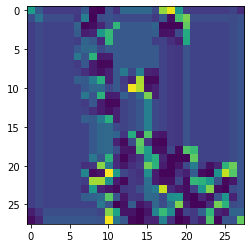

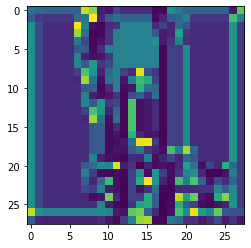

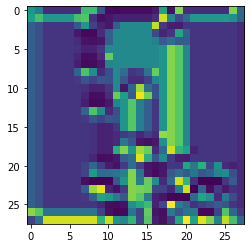

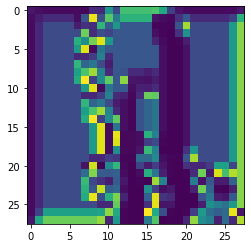

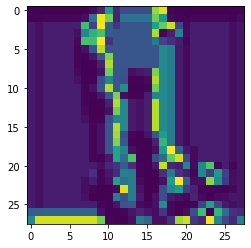

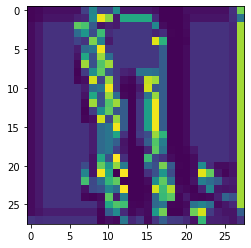

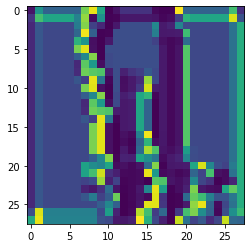

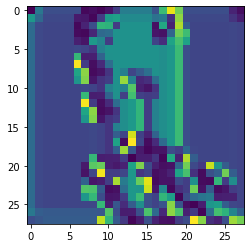

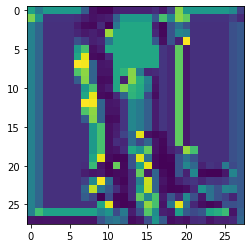

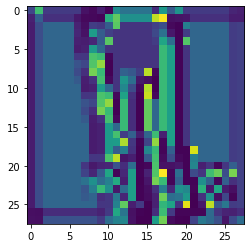

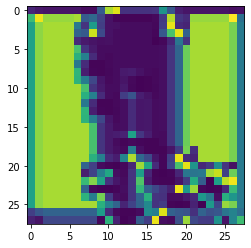

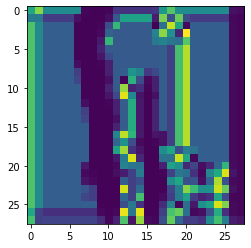

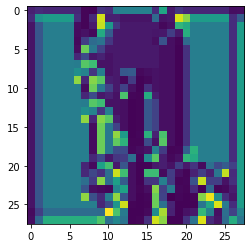

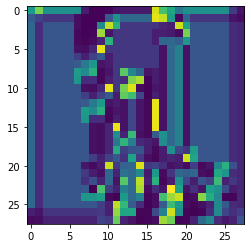

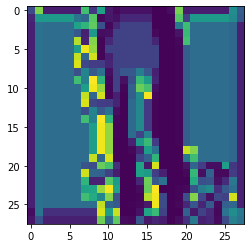

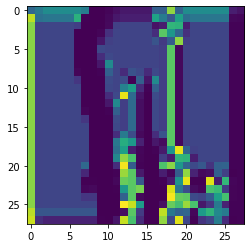

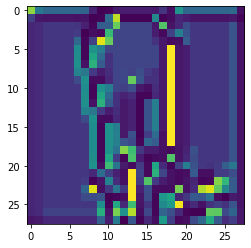

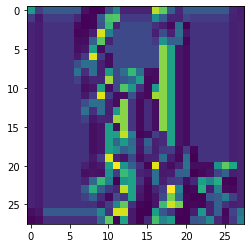

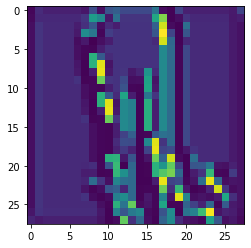

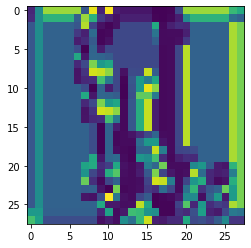

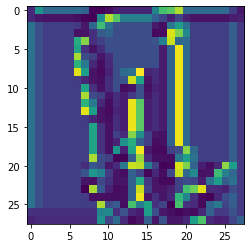

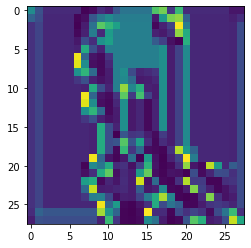

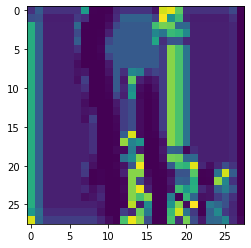

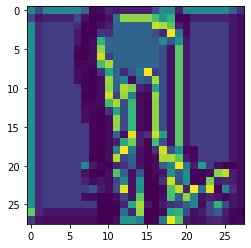

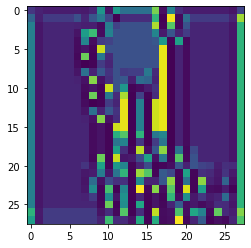

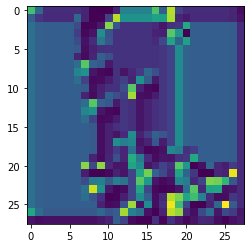

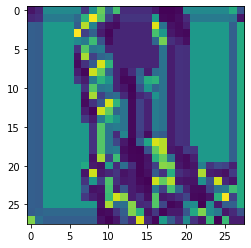

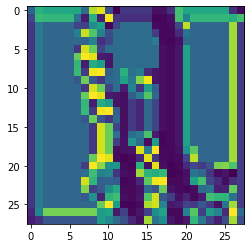

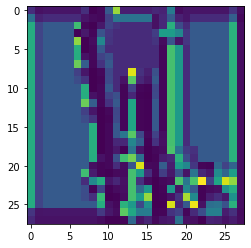

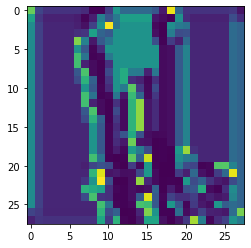

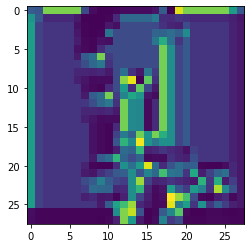

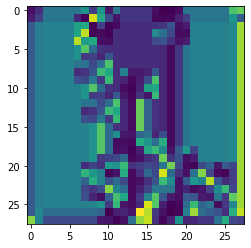

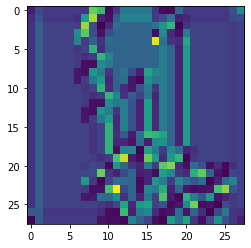

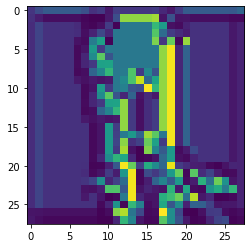

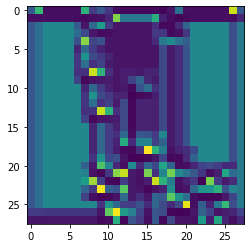

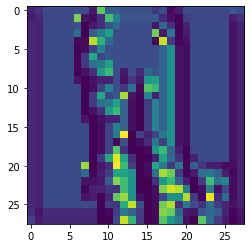

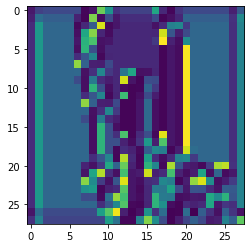

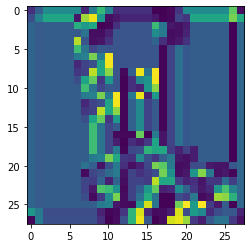

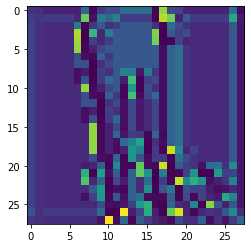

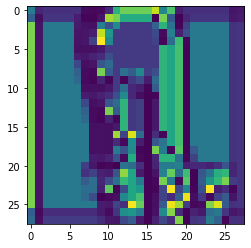

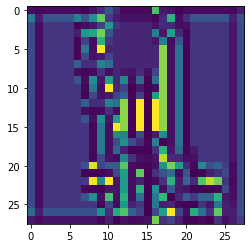

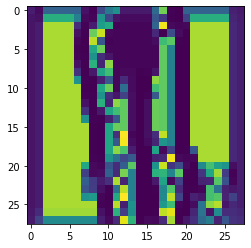

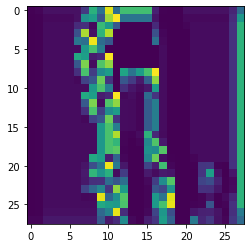

In [ ]:
index = 3
img = train_imgs[index]
print("Original:")
show_image(img)
print("Convolutions:")
for conv in sample_layer("conv1", img):
  show_image(conv)

### 4. Results

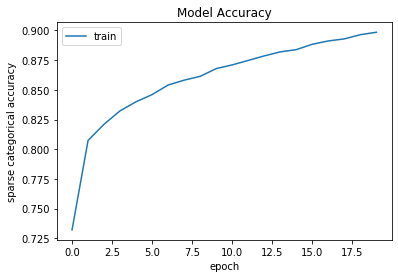

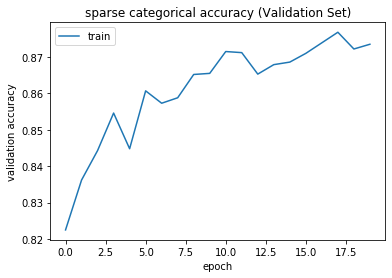

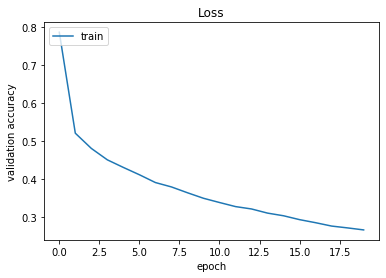

<Figure size 432x288 with 0 Axes>

In [ ]:
# Some codes I used in my final project to plot loss, accuracy, validation_acc...

plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('sparse categorical accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('sparse categorical accuracy (Validation Set)')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy_val.png')

plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [ ]:
for image in test_imgs:
  outline(image)

test_labels = [img.index(max(img)) for img in model.predict(test_imgs).tolist()]

# Submission

Run this cell to submit the results.

In [ ]:
with open("submission.csv", "w", newline='') as file:
  writer = csv.DictWriter(file, fieldnames=["ID", "label"])
  writer.writeheader()
  for i, label in enumerate(test_labels):
    writer.writerow({"ID":i, "label":label})

!kaggle competitions submit -f submission.csv -m test mais202-fall2019

100% 165k/165k [00:05<00:00, 28.2kB/s]
Successfully submitted to MAIS 202 - Kaggle Competition